In [1]:
# Import all sort of things
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
from consts import *
from formulae import *
from potential import *


In [2]:
# Planetary data

# Earth mass (kg)
mE = 5.972e24
# Moon mass (kg)
mM = 7.342e22

# Gravitational constant (m^3/kg/s^2)
G = 6.67430e-11

# Earth-Moon distance (km)
dEM = 384400
# "Relative" gravitational parameter
mu = mM/(mE+mM)
eps = 1e-14



In [3]:
# Lagrange points (L1 and L2)
# L1
xL1 = 0.8369
yL1 = 0 
XL1 = [xL1, yL1, 0, 0]

# L2
xL2 = 1.1556
yL2 = 0
XL2 = [xL2, yL2]

In [4]:
# Initial conditions (alpha0) and Jacobi interval
alpha0 = 50/384400 # initial guess for alpha

# C = 2U(r) - (vx^2 + vy^2)
C_range = [3.1370, 3.1493]

In [5]:
#def mainFun(XL: np.ndarray, mu: float, C_range, IG):
    # XL is the lagrangian point position vector
    # mu is the relative gravitational parameter
    # C_range is the range of Jacobi constants to search for
    # IG is the initial guess for alpha (for Lyapunov orbit)
    


# Compute A at XL
A_xl = A(XL1[:2], mu)
# Diagonalize it
L, V = splin.eig(A_xl)

# Filter small values - eps = 1e-14
# V.real[np.abs(V.real) <= eps] = 0
# V.imag[np.abs(V.imag) <= eps] = 0

# Filter complex numbers with positive imaginary part
Sel =  [(i, x) for i, x in enumerate(L) if isinstance(x, complex) and x.imag > 0]
i_sel = Sel[0][0]
L_sel = Sel[0][1]

# Now take the eigenvector corresponding to that eigenvalue

V_sel = V[:, i_sel]
print(V_sel)
# Angular velocity and period
om_ly = L_sel.imag
T_ly = 2*np.pi/om_ly
# Lyapunov linearized state 
# x(t) = XL + alpha0(cos(om_ly*t)*Re(V_sel) + sin(om_ly*t)*Im(V_sel))
# But we are interested in t = 0 then x(0) = XL + alpha0*Re(V_sel)

# Initial state
x0_ly = XL1 + alpha0*(V_sel.real)
PHI0 = np.eye(4, 4)

X0 = np.concatenate((x0_ly, PHI0.flatten()))


def f_lyp (t_span: np.ndarray, om_ly, alpha0, V):
    # t_span is the time span [0, T]
    # om_ly is the angular velocity
    # alpha0 is the initial guess for alpha
    # V is the eigenvector corresponding to the eigenvalue with positive imaginary part

    X = np.zeros((4, len(t_span)))  
    for i, t in enumerate(t_span):
        X[:, i] = XL1 + alpha0*(np.cos(om_ly*t)*V.real - np.sin(om_ly*t)*V.imag)
    return X




    

[ 1.05809301e-01-1.58426437e-17j  1.58471957e-18+3.79384181e-01j
 -1.07891337e-16+2.46930232e-01j -8.85379859e-01+0.00000000e+00j]


[ 8.36913763e-01  2.06128976e-22 -1.40337326e-20 -1.15163873e-04]
[ 8.36886237e-01 -1.55184919e-07 -1.01005392e-07  1.15163304e-04]


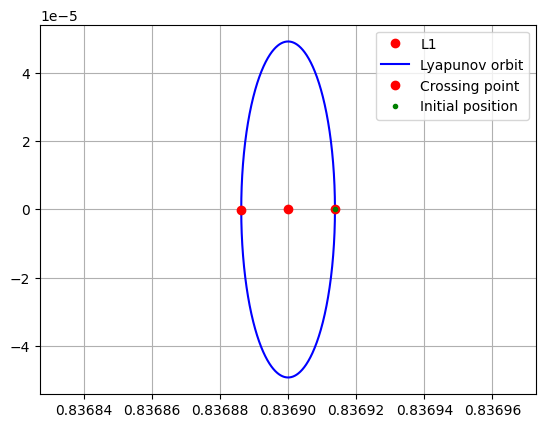

In [9]:
# Plotting cell
# Plot the Lagrange point and the Moon position
import matplotlib.pyplot as plt

t_span = np.linspace(0, 2*np.pi/om_ly, 1000)
X_lyap = f_lyp(t_span, om_ly, alpha0, V_sel)
# Find from this solution the one with a crossing with the x-axis

# Plot the Lagrange point
plt.plot(XL1[0], XL1[1], 'ro', label='L1')
# Plot the Moon position


# Set the aspect ratio to be equal
plt.axis('equal')



# # Plot lyapunov orbit
plt.plot(X_lyap[0, :], X_lyap[1, :],'b', label='Lyapunov orbit')

# From X_lyap take the solution that crosses the x-axis
i_cross = [i for i in range(len(t_span)-1) if X_lyap[1, i] * X_lyap[1,i+1] < 0]

# Plot the crossing point
plt.plot(X_lyap[0,i_cross], X_lyap[1,i_cross], 'ro', label='Crossing point')
print(X_lyap[:, i_cross[0]])
print(X_lyap[:, i_cross[1]])

#Plot initial position
plt.plot( X_lyap[0,0], X_lyap[1,0], 'g.', label='Initial position')
plt.grid()


plt.legend()
plt.show()




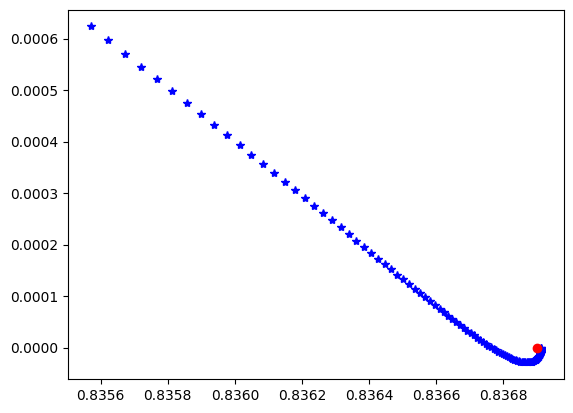

In [13]:
# Take one of the crossing points 
X0 = X_lyap[:, i_cross[0]]
for i in range(4):
    if abs(X0[i]) < eps:
        X0[i] = 0
# Concat the STM
PHI0 = np.eye(4, 4)
Y0 = np.concatenate((X0, PHI0.flatten()))
# Lets integrate the equations of motion
tau_span = np.linspace(0, 1/2, 100)

sol = solve_ivp(f, [0, 1/2], Y0, args = (T_ly, mu), t_eval=tau_span, method='LSODA', rtol=3*eps, atol=eps)

# Plot the solution
plt.plot(sol.y[0, :], sol.y[1, :], 'b*')
plt.plot(XL1[0], XL1[1], 'ro')


In [8]:
# Build the initial guess for iteration
Y_guess = [X0[0], X0[3], T_ly] 
Yt = [0,0]
F_X = 1


while abs(F_X) > 1e-12:
    # Shoot
    DX, DF, F_X = shooting(Y_guess, Yt, mu)
    # Update the guess
    Y_guess = Y_guess + DX
    print(F_X)

# Now integrate the equations of motion
Y0 = [Y_guess[0], 0, 0, Y_guess[1]]
T = Y_guess[2]

tau_span = np.linspace(0, 1/2, 1000)
sol = solve_ivp(f, [0, 1/2], Y0, args = (T, mu), t_eval=tau_span, method='LSODA', rtol=3*eps, atol=eps)

# Plot the solution
plt.plot(sol.y[0, :], sol.y[1, :])
plt.plot(XL1[0], XL1[1], 'ro')



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)